# Supervised Learning Approaches for Predicting Heart Attacks

The puprose of this analysis is to develop models that can reliably classify individuals as being at high risk of a heart attack and identify features/predictors that are associated with heart attack risk. For sake of clarity, this is a supervized learning learning problem, particularly a classification task.

To accomplish this task, various models will be trained with health data and evaluated based on precision and recall (F1 score). These models are: Support Vector Machines, Logistic Regression, K-nearest Neighbors,Naive Bayes, and Tree-based models. To ensure optimal results, the data will first be cleaned and pre-processed.  

The data of interest can be found at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) website. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.gam.api import BSplines
from statsmodels.gam.generalized_additive_model import LogitGam
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, make_scorer, accuracy_score
from sklearn.ensemble import AdaBoostClassifier as AdaBoost, GradientBoostingClassifier as GradBoost, RandomForestClassifier as Forest
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB

## Data Description and Cleaning

The dataset is in tabular format and contains a total of 303 entries and 14 columns/features. There are no null values in any of the columns. However, this does not necessarily imply that there are not missing values, as we will see later. Some columns should be categorical, instead of continous, which is what is suggested from the raw data.

In [2]:
df = pd.read_csv("data/heart.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


There are no null nor NA values in the dataset. In order for results to be interpretable, all the features that are catagorical in type should have descriptive levels and names. After renaming the columns and replacing the integer levels with descriptive names, the categorical features in this dataset are:

1) Sex

2) Chest_Pain_Type 

3) Resting_Electrocardiographic_Results

4) Number_of_major_vessels_colored_by_flourosopy - this is considered a categorical variable since this can only take on 5 values (0-4).

5) Thalassemia 

6) fasting_blood_sugar_greater_120 

7) slope_of_the_peak_exercise_ST_segment

8) exercise_induced_angina


Additionally, the continuous variables should be renamed. After performing this opperation, these columns are:

1) Cholesterol

2) Age

3) Resting_Blood_Pressure

4) ST_depression

5) Maximum_Heart_Rate_Achieved


In [3]:
print("Number of null values \n {}".format(df.isnull().sum().sum()))
print("\nNumber of na values \n {}".format(df.isna().sum().sum()))

Number of null values 
 0

Number of na values 
 0


In [4]:
data = df
data['sex'].replace(1, 'male', inplace=True)
data['sex'].replace(0, 'female', inplace=True)

data['cp'].replace(0, 'typical angina', inplace=True)
data['cp'].replace(1, 'atypical angina', inplace=True)
data['cp'].replace(2, 'non-anginal pain', inplace=True)
data['cp'].replace(3, 'asymptomatic', inplace=True)

data['restecg'].replace(0, 'normal', inplace=True)
data['restecg'].replace(1, 'ST-T wave abnormality', inplace=True)
data['restecg'].replace(2, 'possible hypertrophy', inplace=True)

data['ca'].replace(0, '0', inplace=True)
data['ca'].replace(1, '1', inplace=True)
data['ca'].replace(2, '2', inplace=True)
data['ca'].replace(3, '3', inplace=True)
data['ca'].replace(4, '4', inplace=True)

data['thal'].replace(1, 'normal' , inplace=True)
data['thal'].replace(2, 'fixed defect', inplace=True)
data['thal'].replace(3, 'reversable defect', inplace=True)
data['thal'].replace(0, '0', inplace=True)


data['fbs'].replace(0, 'False', inplace=True)
data['fbs'].replace(1, 'True', inplace=True)

data['slope'].replace(0, 'upsloping', inplace=True)
data['slope'].replace(1, 'flat', inplace=True)
data['slope'].replace(2, 'downsloping', inplace=True)

data['exang'].replace(0, 'no', inplace=True)
data['exang'].replace(1, 'yes', inplace=True)

In [5]:
conts = {
    'chol' : 'Cholesterol',
    'age' : 'Age',
    'trestbps' : 'Resting_Blood_Pressure',
    'oldpeak' : 'ST_depression',
    'thalach' : 'Maximum_Heart_Rate_Achieved'
}
data.rename(columns=conts, inplace=True)
notCats = conts.values()

catTitles = {
    'sex': 'Sex', 
    'cp': 'Chest_Pain_Type', 
    'restecg': 'Resting_Electrocardiographic_Results', 
    'thal': 'Thalassemia', 
    'fbs': 'fasting_blood_sugar_greater_120', 
    'slope': 'slope_of_the_peak_exercise_ST_segment', 
    'exang': 'exercise_induced_angina',
    'ca': 'Number_of_major_vessels_colored_by_flourosopy',
}
data.rename(columns=catTitles, inplace=True)
    
cats = catTitles.values()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Age                                            303 non-null    int64  
 1   Sex                                            303 non-null    object 
 2   Chest_Pain_Type                                303 non-null    object 
 3   Resting_Blood_Pressure                         303 non-null    int64  
 4   Cholesterol                                    303 non-null    int64  
 5   fasting_blood_sugar_greater_120                303 non-null    object 
 6   Resting_Electrocardiographic_Results           303 non-null    object 
 7   Maximum_Heart_Rate_Achieved                    303 non-null    int64  
 8   exercise_induced_angina                        303 non-null    object 
 9   ST_depression                                  303 non

Bar charts and histograms are ideal for identifying missing values and outliers.

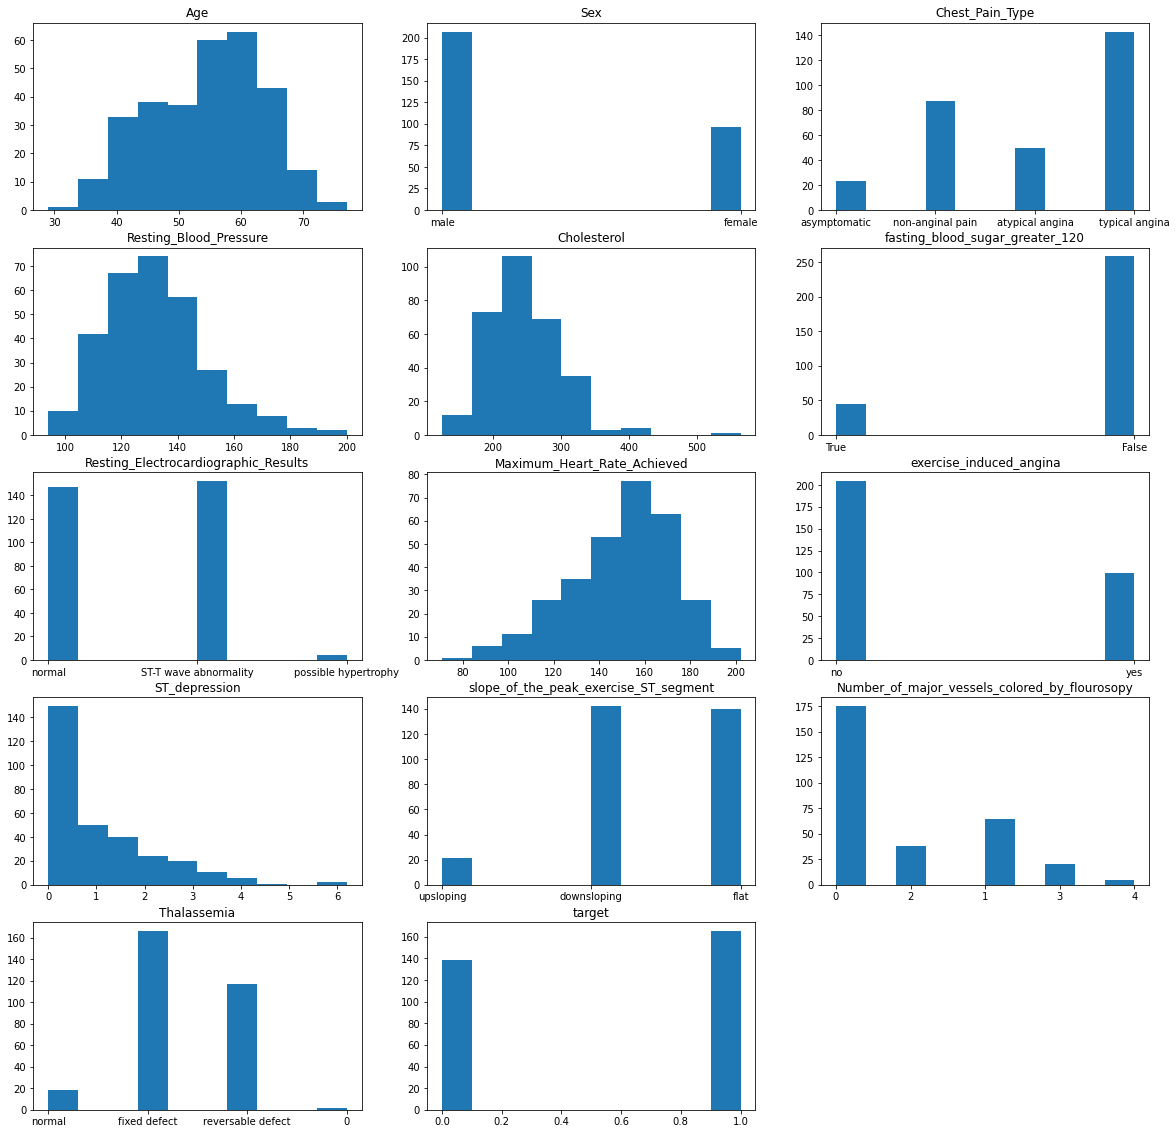

In [6]:
#set ideal size of bar plots
plt.figure(figsize=(20,20))
plt.rc('font', size=10)

#create bar plots of distributions of features
#display them in 5 row by 3 column grid
for i in range(len(data.columns)):
    col = df.columns[i]
    plt.subplot(5, 3, i+1)
    plt.hist(data[col])
    plt.title('{}'.format(col))
    
plt.show()

 There appears to be missing values associated with the Thalassemia column, which is only supposed to have three levels. Instead, there are four. The level labeled '0' contains only two entries. 

There are some outliers, namely in the Cholesterol, Resting_Electrocardiographic_Results and Number_of_major_vessels_colored_by_flourosopy columns. These should not be removed as they do not seem to adversely affect model performance.

In addition, these plots are helpful for observing the distributions of the features. The target variable, heart attack risk, is sufficiently balanced. As a result of this, the accuracy score should be a fair measure of model performance.

ST_depression has a very skewed distribution in which most values for this column are 0. It would seem that these are missing values, but removing this column results in reduced model performance.

According to Complete Case Analysis, if the proportion of observations containing missing values is less than 0.05, then it would be appropriate to remove them from the dataset. Therefore, the missing values associated with Thalassemia may be dropped.

In [6]:
#Thalassemia = 0 represents less than 5 percent of records. Complete Case Analysis allows us to remove this
print("Proportion of records with Thalassemia = 0: ", sum(data['Thalassemia'] == '0') / data.shape[0])

Proportion of records with Thalassemia = 0:  0.006600660066006601


In [7]:
data.drop(data['Thalassemia'][data['Thalassemia'] == '0'].index, inplace=True)

The level, possible hypertrophy, in the Resting_Electrocardiographic_Results column is somewhat rare in the dataset. Therefore, it should be combined with ST-T wave abnormality to form a new level, abnormal. This should improve model training times and model performance. 

In [8]:
#combine into one level for convenience and clarity
data['Resting_Electrocardiographic_Results'].replace('ST-T wave abnormality', 'abnormal', inplace=True)
data['Resting_Electrocardiographic_Results'].replace('possible hypertrophy', 'abnormal', inplace=True)

Split the dataset into a features set and a target set.

In [9]:
#Split the dataset into a features set and a target set.
X = data[[col for col in data.columns if col != "target"]]
y = data['target']

X.describe()

,Age,Resting_Blood_Pressure,Cholesterol,Maximum_Heart_Rate_Achieved,ST_depression
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,54.378738,131.647841,246.504983,149.740864,1.043189
std,9.110950,17.594002,51.915998,22.891031,1.163384
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.000000,120.000000,211.000000,134.000000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000
75%,61.000000,140.000000,275.000000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


Because the continuous-valued features differ significantly in magnitude, scaling may improve performance in some models. It may also improve interpretation of Logisitc Regression parameters, given that all features will be expressed in the same, familiar units after scaling.  The following code normalizes theses features.

In [10]:
#normalize/standardize all numerical feature values. This helps with interpretability and model performance.
for cont in notCats:
    X[cont] = (X[cont] - X[cont].mean()) / X[cont].std() 

In [11]:
#Split the data into a training and test set, where the test set contains 20% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 23)
print(len(X_train), len(X_test))

240 61


### Summary

In summary, the data cleaning processes accomplished the following:

1) Descriptive column names

2) Removal of missing values

3) Assignment of features to the correct data types

4) Scaling of continuous features

5) Combining categorical levels for convenience (Resting_Electrocardiographic_Results)

6) Visualizing feature distributions and identifying outliers

The data contained two missing values for Thalassemia, which were removed. There were some notable outliers, it was decided to not remove them. This might impact model performance, particularly for models that are sensitve to outliers. Now that the data has been sufficiently cleaned, analysis of the data can take place. Coorelation matrices, histograms and bar charts should give insight into how the features are associated with each other and the target variable.

## Exploratory Data Analysis

Some models (e.g. Logistic Regression, Naive Bayes) are sensitve to coorelations between features. In the case of Logistic Regresssion, such coorelations may be indicative of multicollinearity in the model. This negatively impacts model performance and interpretability. Below is a coorelation matrix displaying the pairwise coorelations of each continuous-valued feature in the training set.

There seems to be a moderate negative coorelation between Maximum_Heart_Rate_Achieved and Age. In other words, as Age and ST_depression increases, Maximum_Heart_Rate_Achieved decreases. Furthermore, Maximum_Heart_Rate_Achieved and ST_depression appear to be associated with each other.

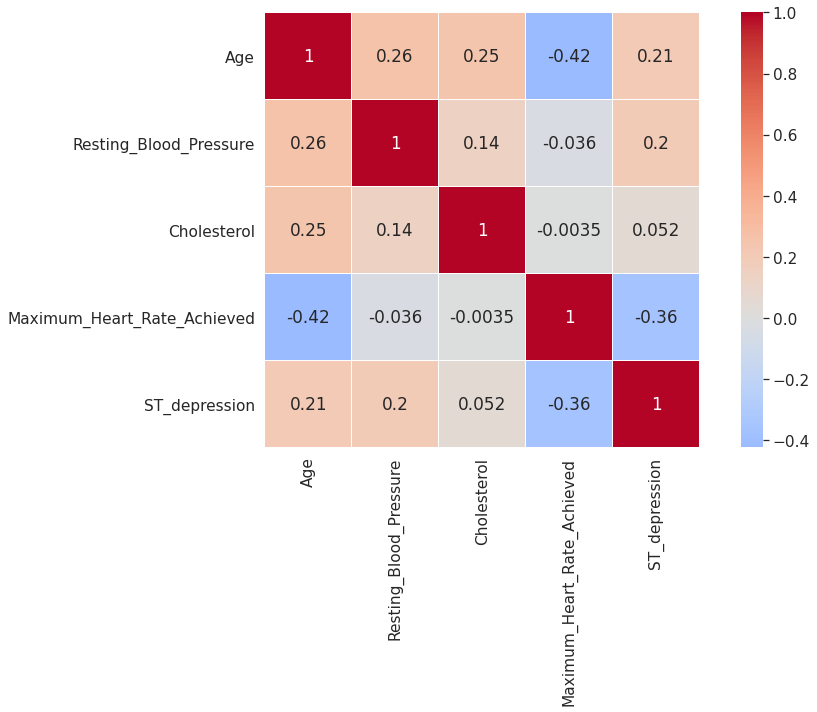

In [34]:
#plot a pretty coorelation matrix
seaborn.set(rc = {'figure.figsize':(15,8)})
seaborn.set(font_scale=1.4)
seaborn.heatmap(
    X_train.corr(),  
    cmap = 'coolwarm',
    linewidths=.1, 
    square=True, 
    yticklabels=True, 
    annot=True,
    center = 0
)

In order to ascertain whether or not there is a true coorelation between these features, a linear model can be fitted with Age and ST_depression as predictors and Maximum_Heart_Rate_Achieved as the response. The alternative hypothesis of the individual T-tests listed in the model summary is that the respective coefficient is not 0. This means that the associated coefficients explain some variability in the response variable.

It appears that both Age and ST_depression are associated with Maximum_Heart_Rate_Achieved. However, more tests will need to be conducted on an individual model basis to determine if these associations are a cause for concern.

In [35]:
#run statistical test to see if if there is an association
model = smf.ols(formula="Maximum_Heart_Rate_Achieved ~ Age + ST_depression", data = X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     Maximum_Heart_Rate_Achieved   R-squared:                       0.235
Model:                                     OLS   Adj. R-squared:                  0.230
Method:                          Least Squares   F-statistic:                     45.72
Date:                         Thu, 10 Mar 2022   Prob (F-statistic):           4.82e-18
Time:                                 13:15:29   Log-Likelihood:                -386.33
No. Observations:                          301   AIC:                             778.7
Df Residuals:                              298   BIC:                             789.8
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

Now let us identify some possible continuous-valued features that may influence heart attack risk.

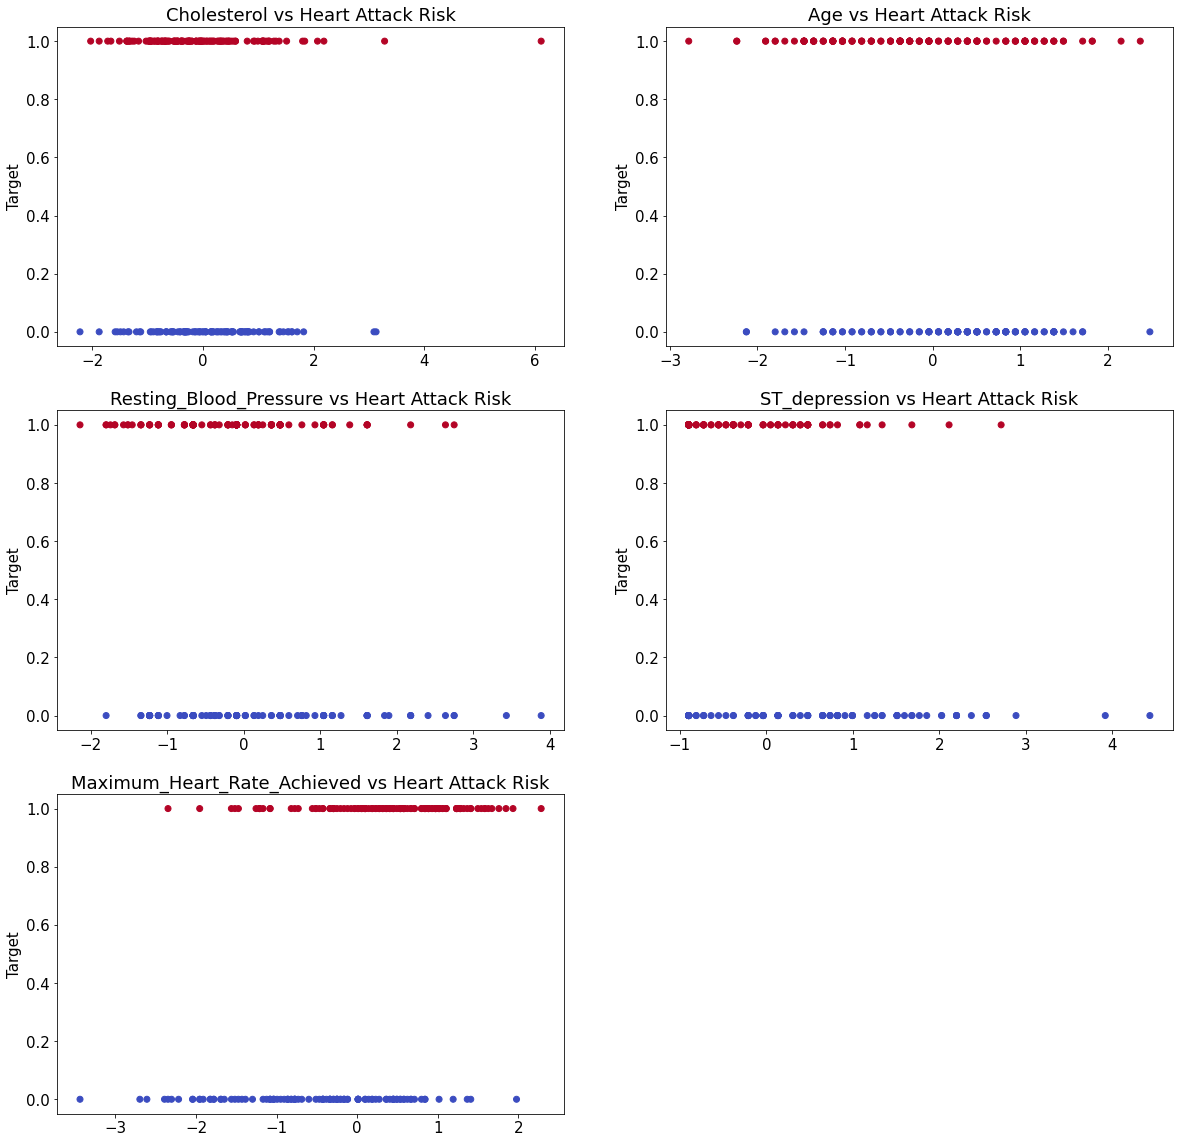

In [12]:
plt.figure(figsize=(20,20))
plt.rc('font', size=15)

i = 1
#plot scatter plots of numerical features vs target
#expect clusters of similar colored points at opposite ends of the specturm
#plot in 3 by 2 grid
for cont in notCats:
    plt.subplot(3, 2, i)
    plt.scatter(X_train[cont], y_train, c=y_train, cmap='coolwarm')
    plt.title("{} vs Heart Attack Risk".format(cont))
    plt.ylabel("Target")
    i += 1

In these scatter plots, red points indicate that the observed individual is at high risk of a heart attack. If a feature is associated with heart attack risk, then one should expect to see a clustering of lighter dots on one side and darker ones on the other side of the plot. This seems to be the case for Maximum_Heart_Rate_Achieved and Resting_Blood_Pressure.

It is somewhat suprising that Cholesteral does not exhibit this pattern, when ignoring the single outlying red observation. 

Now let us explore how categorical features impact the likelyhood of having a heart attack. This is done by using a bar chart. Each chart represents a categorical feature. Along the X-axis are the levels of that feature. Plotted on the Y-axis are the proportions of positve labels for the respective level.

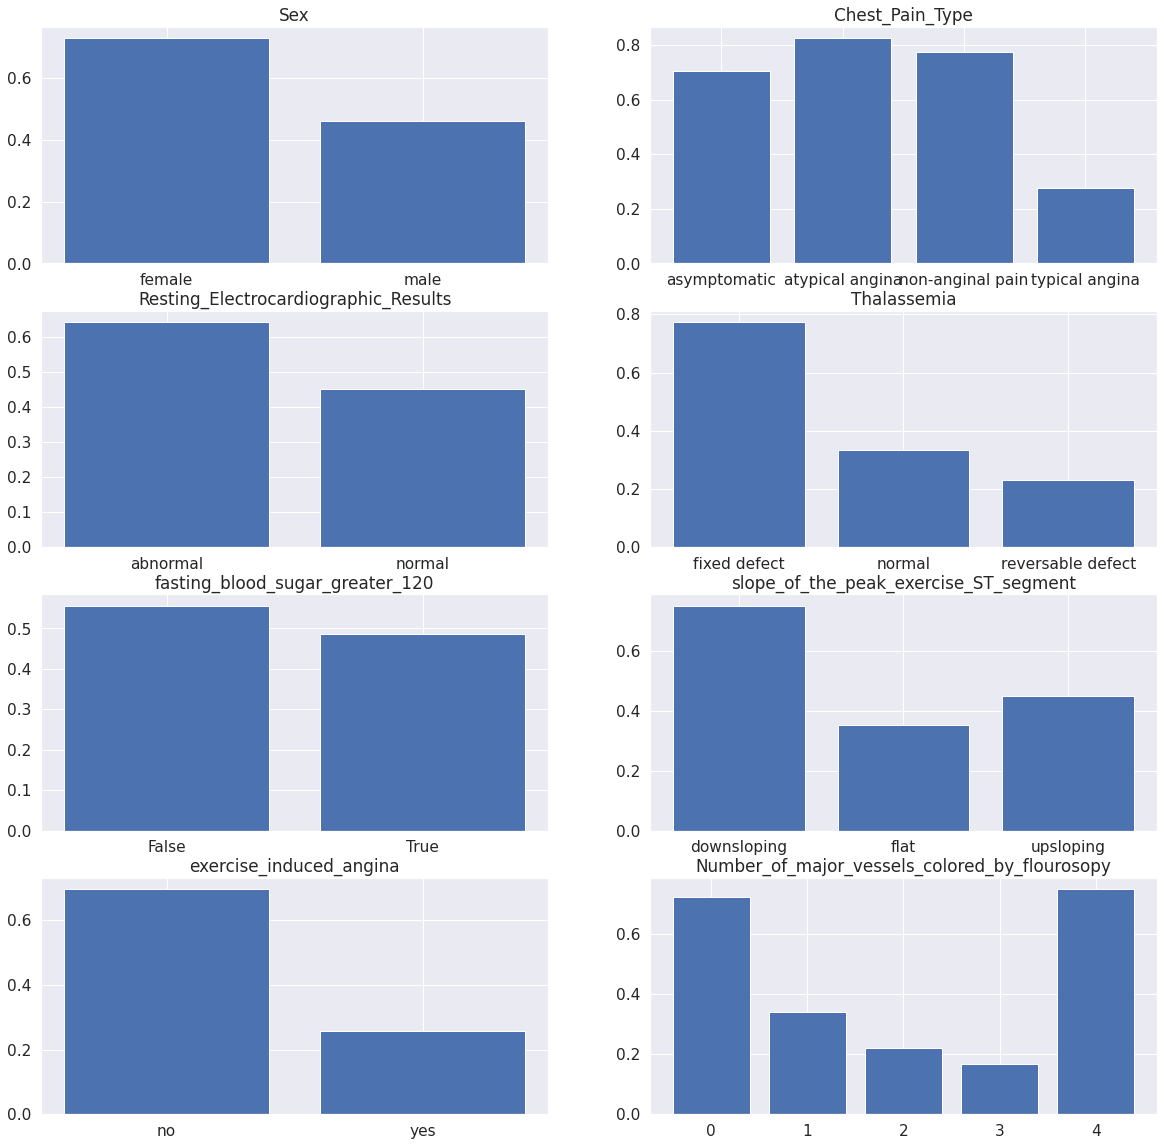

In [40]:
plt.figure(figsize=(20,20))
plt.rc('font', size=12)
train = pd.concat([X_train, y_train], axis=1)

i = 1
#Plot bar charts for each categorical feature
#X-axis : the level
#Y-axis : the proportion of observed individuals classified as being at high risk of a heart attack
#plot in 4 by 2 grid
for col in cats:
    plt.subplot(4, 2, i)
    grp = train.groupby(col).sum().reset_index()
    counts = train.groupby(col).count().reset_index()['target']
        
    plt.bar(grp[col], grp['target'] / counts )
    plt.title('{}'.format(col))
    i+=1
    
plt.show()

An indication that a feature may be associated with the target variable is when the proportion listed in any of the levels is significantly different from the rest. Based on this criteria, Sex and exercise_induced_angina appear to be associated with heart attack risk.

Furthermore, typical angina (Chest_pain_type) may decrease heart attack risk; fixed defect(Thalessemia) may increase heart attack risk, and downsloping (slope_of_the_peak_exercise_ST_segment) may increase risk of a heart attack.

### Summary

Exploratory data analysis revealed that there is a statistically significant coorelation of Maximum_Heart_Rate_Achieved with Age and ST_depression. Bar charts and scatter plots were instrumental in forming hypotheses about what features may have the most impact in predicting the target variable, heart attack risk.

These features are:

1) Maximum_Heart_Rate_Achieved

2) Resting_Blood_Pressure 

3) Sex

4) exercise_induced_angina

In addition, some specific values of categorical features appear to influence the target variable.

1) typical angina

2) fixed defect thalassemia

3) downsloping from peak ST segment


## Model Fitting, Hyperparameter Tuning and Cross Validation

The next phase of the study is to construct machine learning models and identify ideal hyperparameters. This is done through automated cross-validation. The GridSearchCV function selects the best model hyperparameters based on which estimator produced the highest mean cross validation score. By default, a 3-fold cross validation is conducted in which one-third of the data is used to score an estimator and the other two-thirds is used to train it. The evaluation measure by which estimators are compared is the f1_score. 


Because the dataset contains many categorical variables, tree-based models should classify these data in a relatively fast timeframe. One additional advantage to using tree-based models in this context is that they can give insight into what features are likely associated with the target variable. Later we shall see how each of the tree based models ranks the various features of the training set.

In [42]:
#Tune hyperparameters and identiy best model using 3-fold cross validation
grid_forest = GridSearchCV(Forest(), 
             param_grid = {
              'n_estimators' : [2 ** x for x in [*range(1,6)]],
              'ccp_alpha' : [2 ** x for x in [*range(-5,5)]]
             },
            scoring = make_scorer(f1_score),
            n_jobs = 4
            ).fit(pd.get_dummies(X_train), y_train)

In [43]:
ada_grid = GridSearchCV(AdaBoost(), 
             param_grid = {
                'base_estimator' : [Tree(max_depth = 1), Tree(max_depth = 2), Tree(max_depth = 4)],
                'n_estimators' : [2** x for x in [*range(1,6)]],
                'learning_rate' : [2** x for x in [*range(-4,2)]]
             },
            scoring = make_scorer(f1_score),
            n_jobs = 4
            ).fit(pd.get_dummies(X_train), y_train)

In [56]:
boost_grid = GridSearchCV(GradBoost(), 
             param_grid = {
              'n_estimators' : [2 ** x for x in [*range(3,8)]],
              'learning_rate' : [2 ** x for x in [*range(-8,-4)]],
              'max_depth' : [1, 2, 4, 8, 16]
             },
            scoring = make_scorer(f1_score),
            n_jobs = 4
            ).fit(pd.get_dummies(X_train), y_train)

The following two models rely heavily on similarity measure among observations (euclidean distance) to make classifications. These models should benefit most from data normalization, which was conducted earlier during the preprocessing step.

In [59]:
svm_grid = GridSearchCV(SVC(), 
             param_grid = {
              'C' : [2**i for i in range(-5,5)],
              'gamma' : [2**i for i in range(-5,5)], 
              'kernel' : ['poly','rbf', 'linear', 'sigmoid']
             },
            scoring = make_scorer(f1_score),
            n_jobs = 4
            ).fit(pd.get_dummies(X_train), y_train)

In [60]:
knn_grid = GridSearchCV(KNN(), 
             param_grid = {
                 'n_neighbors' : [*range(1,15)],
                 'weights' : ['uniform', 'distance'],
                 'p' : [1,2,3]
             },
            scoring = make_scorer(f1_score),
            n_jobs = 4
            ).fit(pd.get_dummies(X_train), y_train)

The next classifier is one that was not covered in class: the Gaussian Naive Bayesian model. In order to use this model, it is to be assumed that all features are independent from one another. Therefore, the Maximum_Heart_Rate_Achieved should be removed from the training set because it is moderately coorelated with other features. Note coorelation is not the same as association - other features might have non-linear relationships with one another and therefore violate the independence assumption. Nonetheless, if significant feature dependence is the case, then it should be reflected in the model's performance.

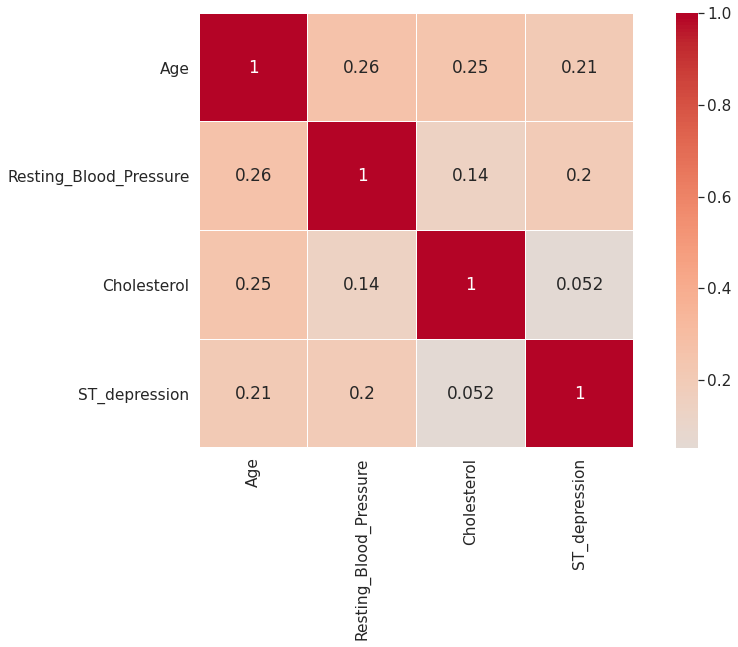

In [61]:
#remove highly coorelated feature from Bayesian training set columns
cols = [col for col in X_train.columns if col != 'Maximum_Heart_Rate_Achieved']
seaborn.set(rc = {'figure.figsize':(15,8)})
seaborn.set(font_scale=1.4)
seaborn.heatmap(
    X_train[cols].corr(),  
    cmap = 'coolwarm',
    linewidths=.1, 
    square=True, 
    yticklabels=True, 
    annot=True,
    center = 0
)

In [62]:
naive_pred = GaussianNB().fit(pd.get_dummies(X_train[cols]), y_train).predict(pd.get_dummies(X_test[cols]))

The next and final model of interest in this study is the Logistic Regression classifier. One factor that can negatively influence performance is multicollinearity. This occurs when a subset of features are a near linear combination from each other. This results in more difficulty solving the optimization problem of finding the best model parameters and results in higher uncertainty of whether or not the parameters belong in the model.

One bellwether of this phenominon is variance inflation factors of model parameters (VIFs). These VIFs are inversely proportional to 1 minus the coefficient of determination (R-squared) of a feature vs. the other features. The larger the VIF, the more likely there is multicolinearity. VIFs larger than 10 are strong indicators of this.

In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_train[notCats]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
vif['features'] = variables.columns
vif

,VIF,features
0,1.083780,Cholesterol
1,1.400434,Age
2,1.127469,Resting_Blood_Pressure
3,1.194406,ST_depression
4,1.384294,Maximum_Heart_Rate_Achieved


Despite there being some moderate coorelation between some features, there is no evidence of multicollinearity associated with any feature. However, VIF is not a foolproof method of determining this. To be on the safe side, the Logistic model should be regularized with a small penalty when fitted. This reduces the model variance with the tradeoff of additional bias. This is akin to performing Ridge Regression, but in a Binomial Regression context.

In [123]:
train = pd.concat([X_train, y_train], axis=1)
pred_vars = " + ".join(col for col in X_train.columns)
formula = "target ~ {}".format(pred_vars)

alpha = np.array([0]*21) #penalty term
alpha[[-1,-2,-3,-4,-5]] = 0.1
LogR_model = smf.logit(formula, data=train).fit_regularized(alpha=alpha, maxitter=1000)
pred_lr = LogR_model.predict(X_test)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.304085458239482
            Iterations: 137
            Function evaluations: 137
            Gradient evaluations: 137


## Results and Model Evaluation

Included in this section is an analysis of model performance when predicting on the test set. Evaluation measures, plots of performance and feature importances should give insight into what valuable information can be mined from these data.

In the context of predicting dire events like a heart attack, measures of correct positve classifications should have high weight in determing the performance of a model. The F1 score is ideal for this since it gives weight to the rate of correct positive predictions and the rate of positive observations classified. Since the target variable is relativelly balanced, the accuracy score would also be a reasonable measure of model performance. 

One goal of this study is to examine what features may be associated with high heart attack risk. This analysis can be conducted with tree-based models or Logistic Regression.

In [72]:
#This function returns evaluation measures, given an instance of GridSearchCV
#Printed are the best model parameters, best f1 and accuracy score and feature importances (if applicable)
def printScore(grid, name):
    print("\n{} best training score : {}".format(name, grid.best_score_))
    print("{} best params: {}".format(name, grid.best_params_))

    pred = grid.best_estimator_.predict(pd.get_dummies(X_test))
    print("{} F1 Score on testing data: {}".format(name, f1_score(y_test, pred)))
    print("{} Accuracy Score on testing data: {}".format(name, accuracy_score(y_test, pred)))
    if hasattr(grid.best_estimator_,'feature_importances_'):
        importances = grid.best_estimator_.feature_importances_
        indices = np.argsort(importances)[::-1]
        features = pd.get_dummies(X).columns

        plt.figure(figsize=(10,10))
        plt.rc('font', size=15)
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()


Random Forest best training score : 0.8551762768843206
Random Forest best params: {'ccp_alpha': 0.03125, 'n_estimators': 32}
Random Forest F1 Score on testing data: 0.8529411764705883
Random Forest Accuracy Score on testing data: 0.8360655737704918


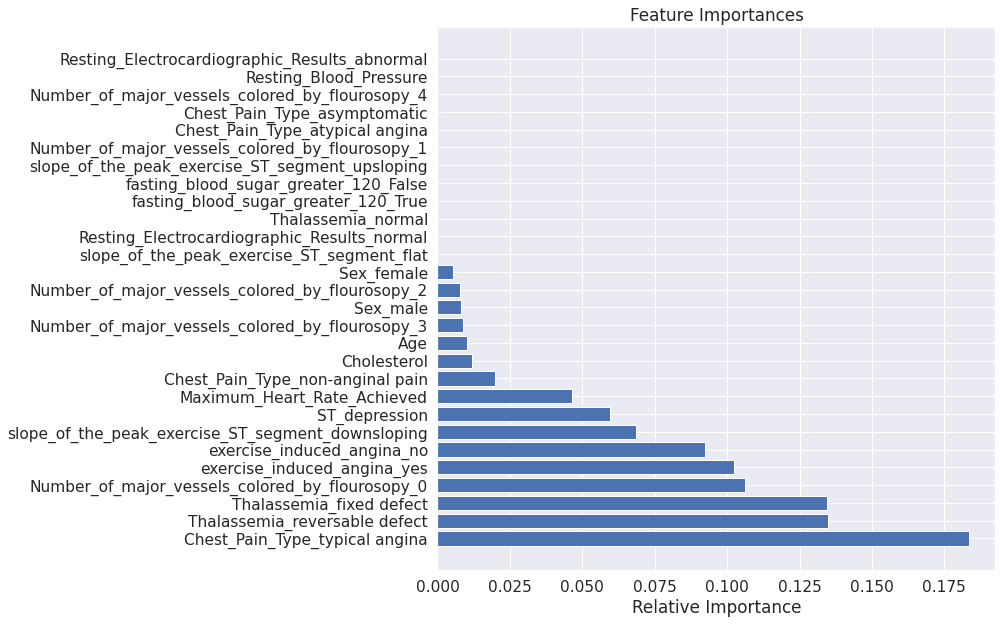

In [73]:
printScore(grid_forest, "Random Forest")

The random forest model has a high test prediction F1 score of 0.85. In addition to this, it appears that typical angina (Chest_Pain_Type), reversable defect (Thalassemia) and fixed defect (Thalassemia) are the three most important incluences on the risk of an individual having a heart attack, according to this model. Interestingly, it seems that blood sugar, blood pressure and certain types of chest pain do not have a large effect.


AdaBoost best training score : 0.846748642960009
AdaBoost best params: {'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'learning_rate': 0.125, 'n_estimators': 32}
AdaBoost F1 Score on testing data: 0.8615384615384615
AdaBoost Accuracy Score on testing data: 0.8524590163934426


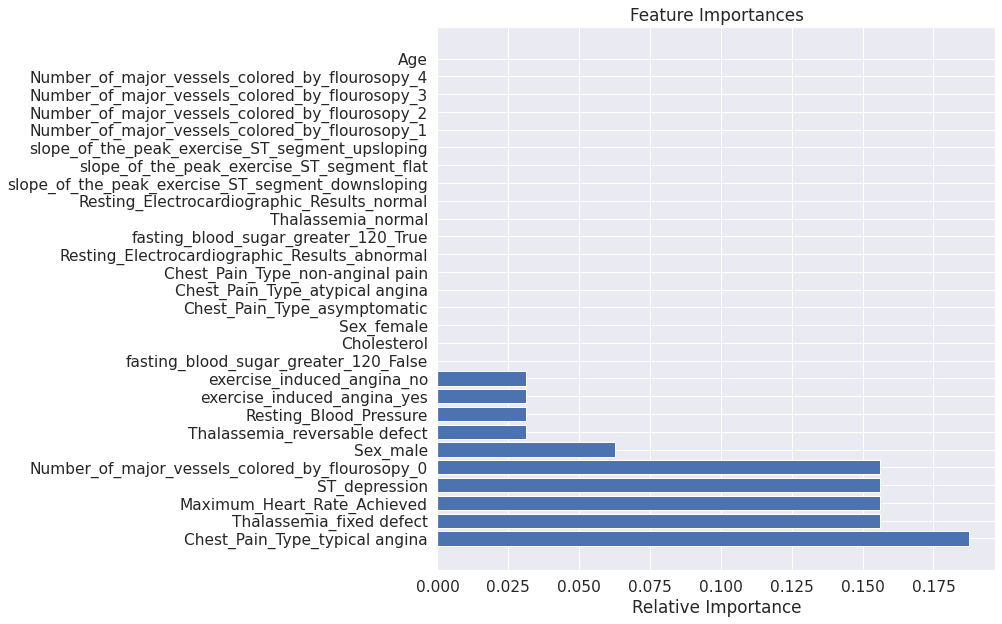

In [74]:
printScore(ada_grid, "AdaBoost")

AdaBoost has a slightly higher evaluation score compared to Random Forest. Also similar is that typical angina (Chest_Pain_Type) is the most influential factor. Fixed defect (Thalassemia) and Maximum_Heart_Rate_Achieved are also listed as influential. One notable difference, though, is that fewer features have influence over the model's prediction power when contrasted with the Random Forest model, even though the ideal number of decision tree estimators for both is 32.


Gradient Boost best training score : 0.8554951065260086
Gradient Boost best params: {'learning_rate': 0.03125, 'max_depth': 1, 'n_estimators': 128}
Gradient Boost F1 Score on testing data: 0.8484848484848486
Gradient Boost Accuracy Score on testing data: 0.8360655737704918


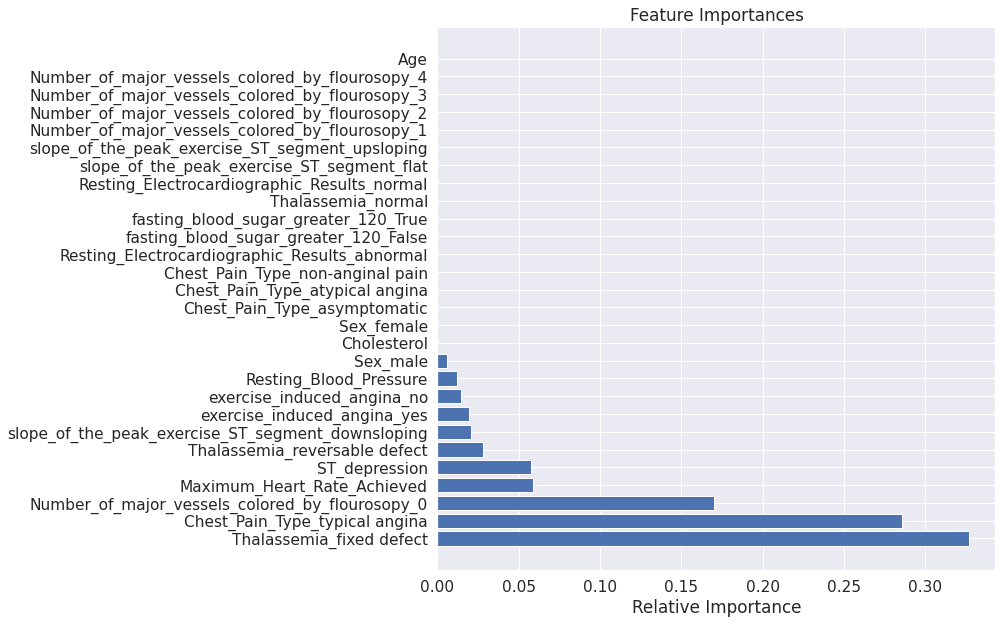

In [75]:
printScore(boost_grid, "Gradient Boost")

The GradientBoosted model has a somewhat lower evaluation score relative to the other two tree-based models. Similarly, though, fixed defect and typical angina are listed as the two most influential factors. In fact, these two are so influential that the other factors appear to have negligible importance. This is likely incorrect and is probably why this model does not perform as well as the others.

In [78]:
printScore(svm_grid, "SVM")
printScore(knn_grid, "KNN")


SVM best training score : 0.8677592249020822
SVM best params: {'C': 0.5, 'gamma': 0.125, 'kernel': 'sigmoid'}
SVM F1 Score on testing data: 0.8529411764705883
SVM Accuracy Score on testing data: 0.8360655737704918

KNN best training score : 0.8672157598540162
KNN best params: {'n_neighbors': 14, 'p': 1, 'weights': 'uniform'}
KNN F1 Score on testing data: 0.8358208955223881
KNN Accuracy Score on testing data: 0.819672131147541


The distance-based models perform similarly well as the tree based models. It is worth noting that training/cross validation was faster for these models, which is likely due to the limited range of possible hyperparameters examined and the prior scaling of the dataset.

In [116]:
print("Bayes testing F1 Score ", f1_score(y_test, naive_pred))
print("Bayes testing Accuracy", accuracy_score(y_test, naive_pred))
print("\nF1 score for logistic regression {}".format(f1_score(y_test, pred_lr >= 0.5)))
print("Accuracy score {}".format(accuracy_score(y_test, LogR_model.predict(X_test) >= 0.5)))

Bayes testing F1 Score  0.8955223880597014
Bayes testing Accuracy 0.8852459016393442

F1 score for logistic regression 0.9117647058823529
Accuracy score 0.9016393442622951


The statistical models are the highest scoring class of models in this study, having F1 scores of near 0.9 and above. The Logistic Regression model is the best performing model for these data, likely meaning that the true population model of heart attack risk has a linear systematic component.

The ROC plot below shows that there is a nice relationship between the False Positive Rate and the True Positive Rate. The rate of true positives remains somewhat high, even when there is a high incidence of false positives.

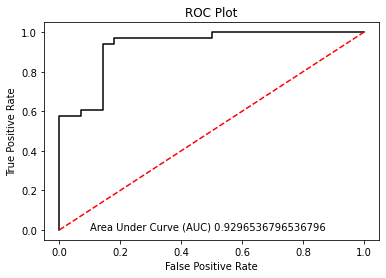

In [69]:
fpr, tpr, th = roc_curve(y_test, pred_lr)
plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'r--')
plt.title("ROC Plot")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0.1,0, "Area Under Curve (AUC) {}".format(roc_auc_score(y_test, pred_lr)))
plt.show()

One advantage of Logistic Regression is its interpretability. It possible to not only determine what features are important, but to what degree they infuence the odds of a target positive. 

In [124]:
LogR_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  240
Model:                          Logit   Df Residuals:                      219
Method:                           MLE   Df Model:                           20
Date:                Thu, 10 Mar 2022   Pseudo R-squ.:                  0.5586
Time:                        16:30:30   Log-Likelihood:                -72.981
converged:                       True   LL-Null:                       -165.35
Covariance Type:            nonrobust   LLR p-value:                 1.149e-28
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              5.6843      1.129      5.035      0.000       3.472       7.897
Sex[T.male]                                           -2.0794      0.649     -3.204      0.001      -3.351      -0.807
Chest_Pain_Type[T.atypical angina]                    -1.5358      0.915     -1.678      0.093      -3.329       0.258
Chest_Pain_Type[T.non-anginal pain]                   -0.7074      0.823     -0.860      0.390      -2.321       0.906
Chest_Pain_Type[T.typical angina]                     -2.4956      0.791     -3.155      0.002      -4.046      -0.945
fasting_blood_sugar_greater_120[T.True]                0.5040      0.682      0.739      0.460      -0.833       1.841
Resting_Electrocardiographic_Results[T.normal]        -0.4832      0.444     -1.089      0.276      -1.353       0.387
exercise_induced_angina[T.yes]                        -0.7323      0.496     -1.476      0.140      -1.704       0.240
slope_of_the_peak_exercise_ST_segment[T.flat]         -1.0356      0.549     -1.888      0.059      -2.111       0.040
slope_of_the_peak_exercise_ST_segment[T.upsloping]    -0.5040      1.000     -0.504      0.614      -2.463       1.455
Number_of_major_vessels_colored_by_flourosopy[T.1]    -1.8590      0.580     -3.206      0.001      -2.996      -0.722
Number_of_major_vessels_colored_by_flourosopy[T.2]    -3.3387      0.921     -3.626      0.000      -5.143      -1.534
Number_of_major_vessels_colored_by_flourosopy[T.3]    -1.9691      0.946     -2.082      0.037      -3.823      -0.115
Number_of_major_vessels_colored_by_flourosopy[T.4]     0.2589      2.881      0.090      0.928      -5.388       5.906
Thalassemia[T.normal]                                 -0.2413      1.025     -0.235      0.814      -2.251       1.768
Thalassemia[T.reversable defect]                      -1.6704      0.491     -3.403      0.001      -2.632      -0.708
Age                                                    0.4484      0.265      1.695      0.090      -0.070       0.967
Resting_Blood_Pressure                                -0.5840      0.225     -2.599      0.009      -1.024      -0.144
Cholesterol                                           -0.3538      0.249     -1.421      0.155      -0.842       0.134
Maximum_Heart_Rate_Achieved                            0.8495      0.317      2.683      0.007       0.229       1.470
ST_depression                                         -0.2711      0.298     -0.909      0.363      -0.856       0.314
======================================================================================================================
"""

### Results Summary

According to the individual T-tests from the summary above, the following factors significantly influence heart attack risk:

1) Intercept (interpreted as average log odds of heart attack given membership in first factor of each categorical feature and average values for each continuous feature).

2) Sex[T.male] 

3) Chest_Pain_Type[T.typical angina]

4) Number_of_major_vessels_colored_by_flourosopy[T.1]

5) Number_of_major_vessels_colored_by_flourosopy[T.2]

6) Thalassemia[T.reversable defect]

7) Resting_Blood_Pressure

8) Maximum_Heart_Rate_Achieved

There is only a 2.4% chance that at least one of these predictors is not actually influential. This is also in general agreement with the feature importances reported by the tree-based models. It is also possible to quantify what these factors mean for the odds of a heart attack. For instance, if an individual's chest pain is typical angina, then their odds of being at risk of a heart attack is reduced by about 92%, keeping everything else constant.

Interestingly, men have 88% lower odds of suffering a heart attack than do women. One factor that increases the odds of heart attack is Maximum_Heart_Rate_Achieved. Increasing the value of that factor by one standard deviation increases the odds of a heart attack by a factor of 2.3, holding all else constant.

According to the the exploratory data analysis conducted prior to modeling, fixed defect(Thalessemia) and downsloping (slope_of_the_peak_exercise_ST_segment) may increase the odds of heart attack risk, as these are factors that influence the significant intercept term. These are also factors that have been identified as relatively important by the tree-based models.

It is possible that there are interactions between features that, when included in the model, may result in higher model performance. For example, there could be an interaction between Cholesterol and Fasting Blood Sugar that influences the odds of a heart attack. However, there does not seem to be evidence of this or any other interaction as most of the systematic variation of the response has already been picked up in the model. What is left is most likely random noise.

In [101]:
formula_inter = formula + "+ Cholesterol:fasting_blood_sugar_greater_120"
LogR_inter = smf.logit(formula_inter, data=train).fit(maxitter=1000)
pred_inter = LogR_inter.predict(X_test)
print("\nF1 score for logistic regression with interaction {}".format(f1_score(y_test, pred_inter >= 0.5)))

Optimization terminated successfully.
         Current function value: 0.303142
         Iterations 8

F1 score for logistic regression with interaction 0.8955223880597014


### Discussion and Conclusion

Various models were trained and evaluated and the Logistic model came out on top, with an F1 Score 0.91 and a 90% accuracy. Features identified as reducing the odds of a heart attack include but are not limited to: being male, typical angina chest pain type, and two blood vessels detected from flourosopy. One factor that increases the chances of a heart attack is the maximum heart rate achieved when observing a patient's heart.

Despite the success of identifying a good model and key influencing features, it is still difficult to indentify how many factors increase the odds of someone having a heart attack. Because of maxtix identifability issues, many levels of various categorical features are wrapped up in the intercept term reported in the Logistic model summary. 

This parameter can be interpreted as the average log odds of heart attack given membership in the first factor of each categorical feature and average values for each continuous feature. 

One possible improvement could be to further optimize the tree-based models and add more details to the feature importances plots. This could be done by adding error bars to indicate confidence intervals. If possible, I would like to estimate how these features affect the risk of heart attack. 